In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import torch
import dgl
import os
from tqdm import tqdm
import jieba
import jieba.analyse
import numpy as np
from nltk.corpus import stopwords
from collections import Counter
from itertools import chain
import nltk
import re

from parallel_processor import process_data
from nltk.tokenize import TweetTokenizer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import wordnet

import dgl.function as fn

import pickle as pkl


os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [2]:
def gc():
    import gc
    gc.collect()

# Data Processing

## Load

In [3]:
# label_names = ['government','sport','business','technology']
with open('datasets/dbpedia/label_names.txt') as fin:
    label_names = [item.replace('\n', '') for item in fin.readlines()]
label_names

['company',
 'school',
 'university',
 'artist',
 'athlete',
 'government',
 'transportation',
 'building',
 'river',
 'mountain',
 'lake',
 'village',
 'animal',
 'plant',
 'tree',
 'album',
 'film',
 'novel',
 'publication',
 'book']

In [32]:
with open('datasets/dbpedia/train.txt') as fin:
    text = [item.replace('\n', '') for item in fin.readlines()]
len(text)

560000

In [35]:
smp_idxs = np.random.randint(0, 5, len(text))
smp_idxs

array([4, 4, 2, ..., 0, 0, 4])

In [36]:
Counter(smp_idxs)

Counter({4: 111894, 2: 112111, 0: 111783, 3: 112168, 1: 112044})

In [37]:
len(smp_idxs), len(text)

(560000, 560000)

In [38]:
text = [text[i] for i in range(len(smp_idxs)) if smp_idxs[i] == 0]
len(text)

111783

In [39]:
text[:4]

['The Unsigned Guide. The Unsigned Guide is an online contacts directory and careers guide for the UK music industry. Founded in 2003 and first published as a printed directory The Unsigned Guide became an online only resource in November 2011.',
 'Presses polytechniques et universitaires romandes. The Presses polytechniques et universitaires romandes ( PPUR literally Polytechnic and university press of French-speaking Switzerland ) is a Swiss academic publishing house.It is based in Lausanne on the Lausanne campus in the Rolex Learning Center.The Presses polytechniques et universitaires romandes has an English-language imprint called EPFL Press.',
 'Adventist Health System. The Adventist Health System is a non-profit health care organization which operates facilities within the Southern and Midwestern regions of the United States. It is run by the Seventh-day Adventist Church.As of 2014 the system supports 44 hospitals and claims to be the largest not-for-profit Protestant healthcare 

In [40]:
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

In [41]:
text = [tokenizer.tokenize(item) for item in tqdm(text)]
text[:2]

100%|██████████| 111783/111783 [00:07<00:00, 14740.78it/s]


[['The Unsigned Guide.',
  'The Unsigned Guide is an online contacts directory and careers guide for the UK music industry.',
  'Founded in 2003 and first published as a printed directory The Unsigned Guide became an online only resource in November 2011.'],
 ['Presses polytechniques et universitaires romandes.',
  'The Presses polytechniques et universitaires romandes ( PPUR literally Polytechnic and university press of French-speaking Switzerland ) is a Swiss academic publishing house.It is based in Lausanne on the Lausanne campus in the Rolex Learning Center.The Presses polytechniques et universitaires romandes has an English-language imprint called EPFL Press.']]

In [8]:
# def paral_tokenize(text):
#     result = [tokenizer.tokenize(item) for item in tqdm(text)]
#     return result

# text = process_data(np.array(text), paral_tokenize, num_workers=20)

In [42]:
text = list(chain.from_iterable(text))
text[:4]

['The Unsigned Guide.',
 'The Unsigned Guide is an online contacts directory and careers guide for the UK music industry.',
 'Founded in 2003 and first published as a printed directory The Unsigned Guide became an online only resource in November 2011.',
 'Presses polytechniques et universitaires romandes.']

* 长度check

In [43]:
lens = [len(item) for item in text]
np.min(lens), np.mean(lens), np.max(lens)

(1, 88.69198844372914, 5456)

In [28]:
long_text_idx = [i for i, l in enumerate(lens) if l > 400]
len(long_text_idx)

7061

In [30]:
[text[i] for i in long_text_idx][:2]

['Angstrem Group ( Russian: ОАО «Ангстрем» named after angstrom ) is a group of Russian companies one of the largest manufacturers of integrated circuits in Eastern Europe.The group includes: OAO Angstrem ( the parent company design and manufacturing of electronic products and semiconductors ) ; OAO Angstrem-M ( custom design of integrated circuits staff training ) ; OAO Angstrem-T ( under-construction plant with 130-90 nm topology ) ; OAO Angstrem-2M NGO Angstrem OAO Antek↑',
 'Calla Records was a small New York City-based independent black owned Soul record label run by Nate McCalla and active c. 1965 to 1977.McCalla was an associate and bodyguard for Morris Levy who headed Roulette Records which had known ties to the mob.Artists recording for the label include J.J. Jackson The Sandpebbles Little Jerry Williams ( aka Swamp Dogg ) Jean Wells The Emotions The Fuzz Lonnie Youngblood The Persuaders and Geraldine Hunt among others.']

In [11]:
cnt = Counter(lens)
cnt = {k: cnt[k] for k in sorted(cnt, key=lambda x: cnt[x], reverse=True)}

<BarContainer object of 1054 artists>

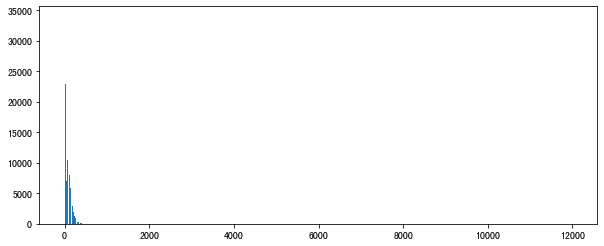

In [12]:
plt.figure(figsize=(10, 4))
plt.bar(list(cnt.keys()), list(cnt.values()))

In [32]:
text = [item for item in text if 30 < len(item) < 400]
len(text)

1357189

## Clean

### NLTK POS-tag

#### nltk tokenizer

In [44]:
# nltk Tokenizer方法
from nltk.stem import WordNetLemmatizer

wnl = WordNetLemmatizer()
# lemmatize nouns
print()

tokenizer = RegexpTokenizer(r'\w+')

tweet = TweetTokenizer()
ps = nltk.PorterStemmer()


weeks = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday', 
         'January','February','March','April','May','June','July','August','September','October','November','December']

weeks = [item.lower() for item in weeks]


def get_nouns(x):
    nouns = []
    for t in tqdm(x):
        t = re.sub(r'[^\w\s]','',t)
        
        tokens = tweet.tokenize(t.lower())
        pos_tags = nltk.pos_tag(tokens)

        noun = set()
        for word,pos in pos_tags:
            if (pos == 'NN' or pos == 'NNP') \
            and word not in stopwords.words('english') \
            and 3 <= len(word) < 40 \
            and word not in weeks:
                noun.add(wnl.lemmatize(word, 'n'))
                
        nouns.append(list(noun))
    return nouns


In [45]:
nouns = process_data(np.array(text), get_nouns, num_workers=24)

100%|██████████| 15776/15776 [00:27<00:00, 576.19it/s]
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [46]:
gc()

In [47]:
[' '.join(item) for item in nouns[:10]]

['guide',
 'industry guide music directory',
 'online guide directory resource',
 '',
 'press switzerland lausanne campus imprint publishing englishlanguage houseit rolex',
 'adventist system health',
 'organization system care adventist health',
 'system adventist protestant provider nation notforprofit churchas healthcare',
 'group music',
 'record production group performance label music industry omg']

In [48]:
nouns = [item for item in nouns if 5 <= len(item)]
len(nouns)

141887

In [49]:
[' '.join(item) for item in nouns[:10]]

['press switzerland lausanne campus imprint publishing englishlanguage houseit rolex',
 'organization system care adventist health',
 'system adventist protestant provider nation notforprofit churchas healthcare',
 'record production group performance label music industry omg',
 'latin reggaeton amongst bachata strategy hip music hop',
 'record portland christopher denny cooper swofford cavity label search oregon',
 'smith elliott fontaine sequence debut acid krebs helio richmond',
 'ltd イオングループ aeon group gurūpu ion æon chiba japan',
 'kong name malaysia sister jusco indonesia china hong',
 'department canada company discount chain corporation subsidiary store target']

关键词抽取

In [67]:
import yake

In [84]:
kw_extractor = yake.KeywordExtractor()
language = "en"
max_ngram_size = 1 #最大关键词语长度
deduplication_threshold = 0.9 #设置在关键词中是否可以重复单词
numOfKeywords = 20 
custom_kw_extractor = yake.KeywordExtractor(lan=language, n=max_ngram_size, dedupLim=deduplication_threshold, top=numOfKeywords, features=None)
keywords = custom_kw_extractor.extract_keywords(text[1])
keywords

[('manufacturers', 0.15831692877998726),
 ('major', 0.29736558256021506),
 ('part', 0.29736558256021506),
 ('output', 0.29736558256021506),
 ('sub-contract', 0.29736558256021506),
 ('motor', 0.29736558256021506),
 ('vehicle', 0.29736558256021506)]

In [86]:
nouns[1]

['motor', 'output', 'vehicle', 'part', 'subcontract']

In [85]:
text[1]

'A major part of their output was under sub-contract to motor vehicle manufacturers.'

In [81]:
nouns[0]

['abbott', 'coachbuilding', 'business', 'name', 'trading']

In [220]:
from sklearn.feature_extraction.text import TfidfTransformer  
from sklearn.feature_extraction.text import CountVectorizer  

vectorizer=CountVectorizer()         #该类会将文本中的词语转换为词频矩阵，矩阵元素a[i][j] 表示j词在i类文本下的词频  
transformer=TfidfTransformer()       #该类会统计每个词语的tf-idf权值  
X=vectorizer.fit_transform([' '.join(item) for item in nouns])   #将文本转为词频矩阵
tfidf=transformer.fit_transform(X)   #计算tf-idf， 

all_tfidf_words = vectorizer.get_feature_names()

* 词频统计

In [50]:
cnt = {}

for noun in tqdm(nouns):
    for word in noun:
        if not cnt.get(word):
            cnt[word] = 1
        else:
            cnt[word] += 1

100%|██████████| 141887/141887 [00:00<00:00, 316670.97it/s]


In [51]:
word_freq = {k: cnt[k] for k in sorted(cnt, key=lambda x: cnt[x], reverse=True)}
word_freq

{'district': 10186,
 'film': 9783,
 'village': 9219,
 'county': 9150,
 'school': 7443,
 'album': 7409,
 'family': 6848,
 'company': 5426,
 'river': 4660,
 'university': 4339,
 'province': 4272,
 'member': 4207,
 'state': 4139,
 'city': 4065,
 'world': 3975,
 'part': 3945,
 'name': 3853,
 'house': 3762,
 'college': 3254,
 'war': 3109,
 'iran': 3010,
 'band': 2987,
 'music': 2901,
 'politician': 2805,
 'genus': 2800,
 'plant': 2714,
 'poland': 2669,
 'book': 2647,
 'york': 2602,
 'series': 2527,
 'group': 2510,
 'john': 2510,
 'voivodeship': 2413,
 'studio': 2375,
 'football': 2317,
 'gmina': 2316,
 'novel': 2295,
 'building': 2267,
 'mountain': 2259,
 'area': 2231,
 'church': 2099,
 'league': 2089,
 'player': 2064,
 'rock': 2032,
 'lake': 1978,
 'california': 1939,
 'story': 1849,
 'west': 1797,
 'capital': 1778,
 'singer': 1751,
 'ship': 1732,
 'sea': 1717,
 'south': 1680,
 'england': 1646,
 'service': 1637,
 'india': 1624,
 'class': 1577,
 'debut': 1556,
 'tributary': 1551,
 'science'

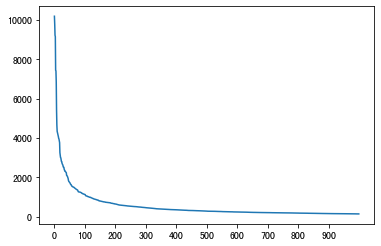

In [52]:
# p = plt.bar(list(word_freq.keys())[:10000], list(word_freq.values())[:10000])

plt.xticks(list(range(0, 1000, 100)))
plt.plot(list(range(0, 1000)), list(word_freq.values())[:1000])

In [53]:
hot_words = list(word_freq.keys())[:300]
hot_words = set(hot_words).difference(label_names)
len(hot_words)

284

In [89]:
nouns = [[jtem for jtem in item if jtem not in hot_words] for item in tqdm(nouns)]

100%|██████████| 1364323/1364323 [00:05<00:00, 270955.23it/s]


In [59]:
# with open('cate_dic.txt', 'r', encoding='utf8') as fin:
#     content = fin.readlines()[0]
# all_cate_dic = eval(content)


In [79]:
nouns = [[jtem for jtem in item if jtem not in inter_words]  for item in tqdm(nouns)]

100%|██████████| 141887/141887 [00:20<00:00, 6774.31it/s]


In [80]:
[' '.join(item) for item in nouns[:10]]

['lausanne imprint houseit rolex',
 'adventist',
 'adventist protestant provider notforprofit churchas healthcare',
 'omg',
 'reggaeton amongst bachata strategy',
 'denny swofford cavity',
 'elliott fontaine sequence acid krebs helio',
 'イオングループ aeon gurūpu ion æon chiba',
 'jusco',
 'company discount target']

In [82]:
film_text = [item for item in nouns if 'athlete' in item]
print(len(film_text))
film_text[:10]

105


[['marcin', 'sadek', 'snatch', 'contribution', 'cord', 'athlete', 'vader'],
 ['shauna', 'derby', 'athlete', 'roller'],
 ['endurance', 'ragsdale', 'athlete'],
 ['athlete', 'roller'],
 ['thamke', 'company', 'athlete', 'anjana'],
 ['medellín', 'archery', 'martínez', 'rendón', 'athlete'],
 ['vladislav',
  'фролов',
  'юрьевич',
  'frolov',
  'athlete',
  'sprint',
  'владислав'],
 ['marianne', 'brussel', 'f1011', 'athlete', 'eventsmarianne', 'javelin'],
 ['middledistance', 't36', 'shvetcov', 'evgenii', 'athlete', 'sprint'],
 ['t46', 'samir', 'athlete', 'eventshe']]

In [83]:
film_text = [item for item in nouns if 'athlete' in item and 'film' in item]
print(len(film_text))
film_text[:10]

2


[['hanja',
  'film',
  'gukgadaepyo',
  '國家代表',
  'kukkataepyohangul',
  'yonghwa',
  '국가대표',
  'athlete'],
 ['film', 'athlete', 'allamerican', 'thorpe', 'teamsthe', 'curtiz']]

In [138]:
# cate_words['athlete']

In [17]:
# abnormal_words = []
# for i, noun in enumerate(tqdm(nouns)):
#     nouns[i] = [word if len(wordnet.synsets(word)) > 0 else abnormal_words.append(word) for word in noun ]

In [18]:
# abnormal_words

# 构图

In [635]:
# G = nx.Graph()

# all_words = set()
# for noun in tqdm(nouns):
#     for i, ni in enumerate(noun):
#         all_words.add(ni)
#         for j, nj in enumerate(list(noun)[i:]):
#             if i == j: continue
                
#             all_words.add(nj)

#             u = list(all_words).index(ni)
#             v = list(all_words).index(nj)
            
#             G.add_node(u)
#             G.add_node(v)
#             G.add_edge(u, v)


In [84]:
def freq_filter(data, min_freq=1, max_freq=1.):
    """
    过滤低频词
    """
    cnter = dict(Counter(list(chain.from_iterable(data))))
    cnter = {k: cnter[k] for k in sorted(cnter, key=lambda x: cnter[x], reverse=True) if cnter[k] > min_freq and cnter[k] / len(data) < max_freq}
    return set(cnter.keys())

In [85]:
all_words = freq_filter(nouns, min_freq=5)
len(all_words)

13518

In [86]:
all_words

{'chrzanów',
 'japanit',
 'outlet',
 'sligo',
 'québécois',
 'ortler',
 'felice',
 'preproduction',
 'submission',
 'centurion',
 'khanna',
 'fonda',
 'schifrin',
 'nino',
 'clipper',
 'escape',
 'mahila',
 'phylogeny',
 'dung',
 'partyhe',
 'sporting',
 'camii',
 'foy',
 'mallee',
 'marist',
 'chisholm',
 'fragrance',
 'wax',
 'apollo',
 'qoli',
 'maple',
 'grape',
 'couldnt',
 'reliance',
 'attraction',
 'talbot',
 'tomentosa',
 'fairfield',
 'cramp',
 'exwife',
 'antoine',
 'jewish',
 'strei',
 'sheriff',
 'trybunalski',
 'bag',
 'gearbox',
 'patience',
 'spa',
 'marketer',
 'councilor',
 'norte',
 'spice',
 'brookline',
 'torus',
 'trafalgar',
 'soy',
 'sent',
 'table',
 'compact',
 'rawska',
 'quo',
 'handball',
 'kebangsaan',
 'brasileiro',
 'mediterranean',
 'górka',
 'cardona',
 'laurier',
 'patterson',
 'yarmouth',
 'aluminum',
 'mistress',
 'vidya',
 'wild',
 'مهدي',
 'voc',
 'orpheus',
 'schultz',
 'xavier',
 'reelection',
 'checklist',
 'vítor',
 'conclusion',
 'sedgwick',


In [87]:
w2i = {w: i for i, w in enumerate(all_words)}
i2w = {v: k for k, v in w2i.items()}

In [88]:
g_mat = np.zeros([len(all_words), len(all_words)])
g_mat.shape

(13518, 13518)

In [89]:
print(f'graph size in mem: {g_mat.size / 1024 / 1024 / 1024}')

graph size in mem: 0.17018646374344826


In [90]:
graphs = []

win = 10

for noun in tqdm(nouns):
    for u in noun:
        noun = noun
        mid_idx = noun.index(u)
        for v in noun[max(0, mid_idx - win): min(len(noun), mid_idx + win)]:
            if not w2i.get(u) or not w2i.get(v): continue
            if u == v: continue
            g_mat[w2i[u], w2i[v]] += 1
#             g_mat[w2i[v], w2i[u]] += 1

100%|██████████| 141887/141887 [00:02<00:00, 64104.74it/s]


In [74]:
# with open('cached/graph_ndarray.bin', 'wb') as fout:
#     pkl.dump(g_mat, fout)

## build graph

### pagerank

networkx

In [91]:
g_nx = nx.from_numpy_array(g_mat)
g = nx.DiGraph(g_nx)

In [92]:
N = len(g_mat)
DAMP = 0.85
N, DAMP
pr = nx.pagerank(g, alpha=DAMP)

In [95]:
# 用1-hop的pv作为排序
cate_words = {}
for ln in label_names:
    cate_words.setdefault(ln, [])
    try:
        adjoin_nodes = [idx for idx, val in enumerate(g_mat[w2i[ln]]) if val != 0]
        print(f'"{ln}" has {len(adjoin_nodes)} adjoin nodes.')

        top_idxs = torch.topk(torch.FloatTensor(list(pr.values()))[adjoin_nodes], 100)[1]
#         top_idxs = torch.topk(g.ndata['pv'][adjoin_nodes], np.sum(np.array(adjoin_nodes) > 0))[1]

        words = []
        for idx in top_idxs:
            words.append(i2w[adjoin_nodes[idx.item()]])

        cate_words[ln].extend(words)
    except Exception as e:
        print(e)
        print(ln)

"company" has 3959 adjoin nodes.
"school" has 3780 adjoin nodes.
"university" has 2808 adjoin nodes.
"artist" has 1309 adjoin nodes.
"athlete" has 172 adjoin nodes.
"government" has 1168 adjoin nodes.
"transportation" has 247 adjoin nodes.
"building" has 1542 adjoin nodes.
"river" has 2265 adjoin nodes.
"mountain" has 1508 adjoin nodes.
"lake" has 1308 adjoin nodes.
"village" has 2147 adjoin nodes.
"animal" has 83 adjoin nodes.
selected index k out of range
animal
"plant" has 1429 adjoin nodes.
"tree" has 633 adjoin nodes.
"album" has 3785 adjoin nodes.
"film" has 5692 adjoin nodes.
"novel" has 2235 adjoin nodes.
"publication" has 356 adjoin nodes.
"book" has 2599 adjoin nodes.


In [96]:
cate_words

{'company': ['film',
  'village',
  'album',
  'school',
  'river',
  'university',
  'book',
  'plant',
  'novel',
  'voivodeship',
  'mountain',
  'building',
  'lake',
  'artist',
  'government',
  'tree',
  'engine',
  'compilation',
  'destroyer',
  'hockey',
  'rugby',
  'constituency',
  'defender',
  'feed',
  'fleet',
  'cargo',
  'shipbuilding',
  'vocalist',
  'moth',
  'duo',
  'soundtrack',
  'publication',
  'frame',
  'draft',
  'escort',
  'bollywood',
  'locomotive',
  'kumar',
  'monoplane',
  'senator',
  'provider',
  'lublin',
  'roof',
  'cultivar',
  'frigate',
  'loan',
  'bosnia',
  'transportation',
  'bolivia',
  'biplane',
  'billboard',
  'nfl',
  'herzegovina',
  'speed',
  'bassist',
  'general',
  'motorcycle',
  'cruiser',
  'pitcher',
  'glacier',
  'chart',
  'luxury',
  'tennis',
  'uboat',
  'return',
  'australian',
  'consumer',
  'rate',
  'enrollment',
  'liner',
  'paperback',
  'flagship',
  'sabha',
  'twoseat',
  'glider',
  'jet',
  'anthol

In [58]:
with open('cate_dic.txt', 'w') as fout:
    fout.writelines(str(cate_words))

In [74]:
intersection = set()
cnt = Counter(list(chain.from_iterable(list(cate_words.values()))))
cnt = {k: cnt[k] for k in sorted(cnt, key=lambda x: cnt[x], reverse=True)}
print(len(cnt))
cnt

6775


{'county': 15,
 'family': 15,
 'city': 15,
 'part': 15,
 'world': 15,
 'member': 15,
 'name': 15,
 'state': 15,
 'house': 15,
 'war': 15,
 'college': 15,
 'band': 15,
 'john': 15,
 'york': 15,
 'group': 15,
 'series': 15,
 'poland': 15,
 'area': 15,
 'california': 15,
 'rock': 15,
 'west': 15,
 'capital': 15,
 'service': 15,
 'south': 15,
 'science': 15,
 'england': 15,
 'time': 15,
 'street': 15,
 'canada': 15,
 'career': 15,
 'range': 15,
 'year': 15,
 'park': 15,
 'home': 15,
 'germany': 15,
 'development': 15,
 'george': 15,
 'island': 15,
 'community': 15,
 'country': 15,
 'william': 15,
 'road': 15,
 'history': 15,
 'america': 15,
 'union': 15,
 'number': 15,
 'japan': 15,
 'art': 15,
 'research': 15,
 'production': 15,
 'pennsylvania': 15,
 'washington': 15,
 'design': 15,
 'corporation': 15,
 'coast': 15,
 'side': 15,
 'system': 15,
 'magazine': 15,
 'texas': 15,
 'line': 15,
 'massachusetts': 15,
 'death': 15,
 'robert': 15,
 'day': 15,
 'summer': 15,
 'award': 15,
 'water': 1

In [78]:
inter_words = [k for k, v in cnt.items() if v > 6 and k not in label_names]
print(len(inter_words))
inter_words

1880


['county',
 'family',
 'city',
 'part',
 'world',
 'member',
 'name',
 'state',
 'house',
 'war',
 'college',
 'band',
 'john',
 'york',
 'group',
 'series',
 'poland',
 'area',
 'california',
 'rock',
 'west',
 'capital',
 'service',
 'south',
 'science',
 'england',
 'time',
 'street',
 'canada',
 'career',
 'range',
 'year',
 'park',
 'home',
 'germany',
 'development',
 'george',
 'island',
 'community',
 'country',
 'william',
 'road',
 'history',
 'america',
 'union',
 'number',
 'japan',
 'art',
 'research',
 'production',
 'pennsylvania',
 'washington',
 'design',
 'corporation',
 'coast',
 'side',
 'system',
 'magazine',
 'texas',
 'line',
 'massachusetts',
 'death',
 'robert',
 'day',
 'summer',
 'award',
 'water',
 'hill',
 'virginia',
 'car',
 'inc',
 'department',
 'place',
 'engineering',
 'site',
 'kingdom',
 'ontario',
 'division',
 'joseph',
 'border',
 'henry',
 'australia',
 'power',
 'mexico',
 'land',
 'point',
 'pinyin',
 'saint',
 'gold',
 'industry',
 'ireland',

DGL

In [42]:
g = dgl.DGLGraph(g_nx)
g

Graph(num_nodes=38732, num_edges=7150186,
      ndata_schemes={}
      edata_schemes={})

In [43]:
# with open('cached/graph_dgl.bin', 'wb') as fout:
#     pkl.dump(g, fout)

In [44]:
N = len(g_mat)
DAMP = 0.85
N, DAMP

(38732, 0.85)

In [46]:
def pagerank(g):
    g.ndata['pv'] = g.ndata['pv'] / g.ndata['deg']
    
    g.update_all(message_func=fn.copy_src(src='pv', out='m'), 
                 reduce_func=fn.sum(msg='m', out='m_sum'))
    
    g.ndata['pv'] = (1 - DAMP) / N + DAMP * g.ndata['m_sum']

In [47]:
g.ndata['pv'] = torch.ones(N) / N
# g.ndata['pv'] = torch.rand(N) / N

g.ndata['deg'] = g.out_degrees(g.nodes()).float()

for i in tqdm(range(100)):
    pagerank(g)

100%|██████████| 100/100 [00:00<00:00, 487.31it/s]


In [48]:
g.ndata['pv']

tensor([3.8728e-06, 5.9779e-06, 1.3985e-05,  ..., 1.6379e-05, 4.7658e-05,
        1.1681e-05])

* government
* sport
* business
* technology


In [49]:
# 用1-hop的pv作为排序
cate_words = {}
for ln in label_names:
    cate_words.setdefault(ln, [])
    try:
        adjoin_nodes = [idx for idx, val in enumerate(g_mat[w2i[ln]]) if val != 0]
        print(f'"{ln}" has {len(adjoin_nodes)} adjoin nodes.')

        top_idxs = torch.topk(g.ndata['pv'][adjoin_nodes], 100)[1]

        words = []
        for idx in top_idxs:
            words.append(i2w[adjoin_nodes[idx.item()]])

        cate_words[ln].extend(words)
    except:
        print(ln)

"company" has 9771 adjoin nodes.
"school" has 13136 adjoin nodes.
"university" has 9862 adjoin nodes.
"artist" has 6028 adjoin nodes.
"athlete" has 953 adjoin nodes.
"government" has 4456 adjoin nodes.
"transportation" has 1255 adjoin nodes.
"building" has 5581 adjoin nodes.
"river" has 7938 adjoin nodes.
"mountain" has 6192 adjoin nodes.
"lake" has 4533 adjoin nodes.
"village" has 8080 adjoin nodes.
"animal" has 714 adjoin nodes.
"plant" has 4924 adjoin nodes.
"tree" has 2945 adjoin nodes.
"album" has 10934 adjoin nodes.
"film" has 14533 adjoin nodes.
"novel" has 8155 adjoin nodes.
"publication" has 1674 adjoin nodes.
"book" has 9379 adjoin nodes.


In [50]:
cate_words

{'company': ['name',
  'family',
  'film',
  'school',
  'district',
  'village',
  'part',
  'album',
  'world',
  'university',
  'river',
  'city',
  'series',
  'county',
  'book',
  'july',
  'music',
  'september',
  'genus',
  'member',
  'march',
  'house',
  'war',
  'group',
  'band',
  'december',
  'john',
  'story',
  'novel',
  'studio',
  'state',
  'south',
  'college',
  'june',
  'york',
  'year',
  'debut',
  'mountain',
  'drama',
  'plant',
  'title',
  'april',
  'life',
  'career',
  'time',
  'work',
  'california',
  'service',
  'singer',
  'town',
  'record',
  'west',
  'church',
  'north',
  'artist',
  'building',
  'number',
  'island',
  'rock',
  'league',
  'team',
  'football',
  'area',
  'footballer',
  'writer',
  'george',
  'ship',
  'east',
  'england',
  'author',
  'science',
  'century',
  'lake',
  'road',
  'player',
  'business',
  'august',
  'side',
  'october',
  'education',
  'comedy',
  'class',
  'canada',
  'province',
  'home',
  

In [ ]:
co_occu = set()
for c, words in cate_words.items():
    co_occu

In [95]:
tech_ws = cate_words['technology']
bus_ws = cate_words['business']
sport_ws = cate_words['sport']
poli_ws = cate_words['government']

In [96]:
set(sport_ws).intersection(bus_ws).intersection(tech_ws).intersection(poli_ws)

{'company',
 'friday',
 'group',
 'monday',
 'thursday',
 'time',
 'today',
 'tuesday',
 'week',
 'world',
 'year',
 'yesterday',
 'york'}

In [97]:
set(sport_ws).difference(bus_ws).difference(tech_ws).difference(poli_ws)

{'action',
 'anyone',
 'appeal',
 'arbitration',
 'ban',
 'baseball',
 'basketball',
 'bernie',
 'blood',
 'body',
 'cas',
 'catch',
 'champion',
 'committee',
 'competition',
 'cricket',
 'cup',
 'cycling',
 'decision',
 'doping',
 'drug',
 'ecclestone',
 'effort',
 'event',
 'fishing',
 'football',
 'ford',
 'formula',
 'fox',
 'france',
 'funding',
 'future',
 'game',
 'gold',
 'gymnast',
 'hamilton',
 'hamm',
 'head',
 'hearing',
 'history',
 'hockey',
 'honda',
 'ice',
 'lausanne',
 'league',
 'london',
 'love',
 'matthew',
 'medal',
 'money',
 'montgomery',
 'motor',
 'nascar',
 'nation',
 'night',
 'olympic',
 'paul',
 'pinsent',
 'prix',
 'race',
 'retirement',
 'rugby',
 'safety',
 'scandal',
 'season',
 'series',
 'switzerland',
 'taeyoung',
 'team',
 'television',
 'test',
 'top',
 'use',
 'utility',
 'vehicle',
 'victory',
 'win',
 'yang'}

In [98]:
set(bus_ws).difference(sport_ws).difference(tech_ws).difference(poli_ws)

{'bank',
 'battle',
 'bid',
 'cash',
 'confidence',
 'francisco',
 'insurance',
 'intelligence',
 'investment',
 'lenovo',
 'loss',
 'move',
 'online',
 'oracle',
 'peoplesoft',
 'priority',
 'process',
 'quote',
 'sale',
 'stake',
 'stock',
 'survey',
 'takeover',
 'technology',
 'unit',
 'wire'}

In [99]:
set(tech_ws).difference(bus_ws).difference(sport_ws).difference(poli_ws)

{'acquisition',
 'amd',
 'apple',
 'center',
 'chip',
 'cisco',
 'conference',
 'contract',
 'demand',
 'development',
 'device',
 'dvd',
 'email',
 'engine',
 'google',
 'identification',
 'institute',
 'intel',
 'iran',
 'network',
 'officer',
 'patent',
 'performance',
 'processor',
 'radio',
 'science',
 'sector',
 'semiconductor',
 'sony',
 'space',
 'storage',
 'video',
 'web'}

In [100]:
set(poli_ws).difference(bus_ws).difference(tech_ws).difference(sport_ws)

{'agency',
 'aid',
 'air',
 'ariel',
 'attack',
 'baghdad',
 'bill',
 'city',
 'coalition',
 'conflict',
 'crisis',
 'crude',
 'darfur',
 'department',
 'election',
 'energy',
 'hostage',
 'iraq',
 'iraqi',
 'labor',
 'law',
 'leader',
 'militia',
 'minister',
 'office',
 'opposition',
 'parliament',
 'party',
 'peace',
 'police',
 'press',
 'program',
 'rate',
 'rebel',
 'region',
 'release',
 'secretary',
 'spending',
 'spokesman',
 'strike',
 'sudan',
 'sunday',
 'trade',
 'union',
 'violence',
 'war'}

### GNN

In [5]:
with open('cached/graph_networkx.bin', 'rb') as fin:
    g_nx = pkl.load(fin)

In [39]:
from node2vec import Node2Vec

In [ ]:
node2vec = Node2Vec(g, dimensions=64, walk_length=16, num_walks=20, p=1.3, q=0.8)


Computing transition probabilities:  30%|██▉       | 13402/45408 [4:56:04<9:21:17,  1.05s/it] 

In [ ]:
model = node2vec.fit(window=10, min_count=1)

In [ ]:
with open('node2vec_model.pkl', 'wb') as fout:
    pkl.dump(node2vec, fout)

In [ ]:
cate_sims = {}
for ln in label_names:
    print(ln)
    
    ws = []
    for i, j in model.most_similar(str(w2i[ln]), topn=100):
        ws.append([i2w[int(i)], j])
        print(i2w[int(i)], j)
    print('-' * 40)
    cate_sims[ln] = ws

In [ ]:
model.save('node2vec-model/agnews_noun_n2v_p1.3_q.8_wl16_nw20.bin')

In [ ]:
123

* TextBlob

作为nltk的替代，TextBlob库能够更进一步进行词组划分，例如“computer science”会被当做一个单词，而非"computer"和"science"

In [46]:
# !/chj/conda_store/envs/nlp_task/bin/pip install textblob

In [36]:
from textblob import TextBlob
txt = """Natural language processing (NLP) is a field of computer science, artificial intelligence, and computational linguistics concerned with the inter
actions between computers and human (natural) languages."""
txt = text[0]
blob = TextBlob(txt)
print(type(blob.noun_phrases))
print(list(blob.noun_phrases))

<class 'textblob.blob.WordList'>
['wall', 'claw', 'black', 'reuters', 'reuters', 'short-sellers', 'wall', "street 's"]
